

Please upload/move `train_32x32.mat` and `test_32x32.mat` to current working directory before running the cells below.

In [0]:
# Load packages
import os, time
import scipy.io as sio
import tensorflow as tf
import numpy as np
from sys import exit
from matplotlib import pyplot as plt
# Set seeds
np.random.seed(0)
tf.set_random_seed(0)
# Include the line below only when using Jupyter notebook
# get_ipython().magic('matplotlib inline')

In [0]:
# A class of one channel of all images
class SVHNDataset:
    def __init__(self, chan, db_path='/content', use_extra=False):
        print("Loading files")
#         self.data_dims = [32, 32]
        self.name = "svhn"
        self.train_file = os.path.join(db_path, "train_32x32.mat") # path for train file on VM
        self.test_file = os.path.join(db_path, "test_32x32.mat") # path for test file on VM
        print(self.train_file)
        
        # Load training images
        if os.path.isfile(self.train_file):
            mat = sio.loadmat(self.train_file) # entire train file
            self.train_label = mat['y']
            self.train_image = mat['X'] # 32 * 32 * 3 * 73257
            self.train_image = np.transpose(self.train_image, [3, 0, 1, 2]) \
                               [:, :, :, chan] # take the first channel
            self.train_image = np.clip(self.train_image / 255.0, a_min=0.0, a_max=1.0)
        else:
            print("SVHN dataset train files not found")
            exit(-1)
        self.train_batch_ptr = 0
#         self.train_size = self.train_image.shape[-1]
        self.train_size = self.train_image.shape[0]

        if os.path.isfile(self.test_file):
            mat = sio.loadmat(self.test_file) # entire test file
            self.test_label = mat['y']
            self.test_image = mat['X'].astype(np.float32) 
            self.test_image = np.transpose(self.test_image, [3, 0, 1, 2]) \
                              [:, :, :, chan]
            self.test_image = np.clip(self.test_image / 255.0, a_min=0.0, a_max=1.0)
        else:
            print("SVHN dataset test files not found")
            exit(-1)
        self.test_batch_ptr = 0
#         self.test_size = self.test_image.shape[-1]
        self.test_size = self.test_image.shape[0]
        print("SVHN_R loaded into memory")

    def next_batch(self, batch_size):
        prev_batch_ptr = self.train_batch_ptr
        self.train_batch_ptr += batch_size
#         if self.train_batch_ptr > self.train_image.shape[-1]:       # Note the ordering of dimensions
        if self.train_batch_ptr > self.train_image.shape[0]:
            self.train_batch_ptr = batch_size
            prev_batch_ptr = 0
#         return np.transpose(self.train_image[:, :, :, prev_batch_ptr:self.train_batch_ptr], (3, 0, 1, 2))
        return self.train_image[prev_batch_ptr:self.train_batch_ptr, :, :]

    def batch_by_index(self, batch_start, batch_end):
#         return np.transpose(self.train_image[:, :, :, batch_start:batch_end], (3, 0, 1, 2))
        return self.train_image[batch_start:batch_end, :, :]

    def next_test_batch(self, batch_size):
        prev_batch_ptr = self.test_batch_ptr
        self.test_batch_ptr += batch_size
#         if self.test_batch_ptr > self.test_image.shape[-1]:
        if self.test_batch_ptr > self.test_image.shape[0]:
            self.test_batch_ptr = batch_size
            prev_batch_ptr = 0
#         return np.transpose(self.test_image[:, :, :, prev_batch_ptr:self.test_batch_ptr], (3, 0, 1, 2))
        return self.test_image[prev_batch_ptr:self.test_batch_ptr, :, :], self.test_label[prev_batch_ptr:self.test_batch_ptr]

    def reset(self):
        self.train_batch_ptr = 0
        self.test_batch_ptr = 0

In [0]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    https://jmetzen.github.io/2015-11-27/vae.html
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.relu, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
#        self.x = tf.placeholder(tf.float32, [None, 32, 32, 1])
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = self._recognition_network(network_weights["weights_recog"], 
                                           network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                                dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = self._generator_network(network_weights["weights_gener"],
                               network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1, n_hidden_gener_2, n_input, n_z):
        all_weights = dict()
        initializer = tf.contrib.layers.xavier_initializer()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(initializer(shape = [n_input, n_hidden_recog_1])),
            'h2': tf.Variable(initializer(shape = [n_hidden_recog_1, n_hidden_recog_2])),
            'out_mean': tf.Variable(initializer(shape = [n_hidden_recog_2, n_z])),
            'out_log_sigma': tf.Variable(initializer(shape = [n_hidden_recog_2, n_z]))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(initializer(shape = [n_z, n_hidden_gener_1])),
            'h2': tf.Variable(initializer(shape = [n_hidden_gener_1, n_hidden_gener_2])),
            'out_mean': tf.Variable(initializer(shape = [n_hidden_gener_2, n_input])),
            'out_log_sigma': tf.Variable(initializer(shape = [n_hidden_gener_2, n_input]))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2']))
#        e_conv1 = self.transfer_fct(tf.layers.conv2d(self.x, 16, 5, strides=2, name='e_conv1'))
#        e_conv2 = self.transfer_fct(tf.layers.conv2d(e_conv1, 32, 5, strides=2,   name='e_conv2'))
#        e_conv2_flat = tf.reshape(e_conv2, [batch_size, -1])
#        z_mean = tf.layers.dense(e_conv2_flat, 32, name='mean')
#        z_log_sigma_sq = tf.layers.dense(e_conv2_flat, 32, name='stddev')
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                         biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                          biases['out_mean']))
#        d_fc1 = self.transfer_fct(tf.layers.dense(self.z, 7*7*32, name='d_fc1'))
#        d_fc1 = tf.reshape(d_fc1, [batch_size, 7,7,32])
#        e_transpose_conv1 = self.transfer_fct(tf.layers.conv2d_transpose(d_fc1, 16, 5, strides=2, name='e_transpose_conv1'))
#        e_transpose_conv2 = self.transfer_fct(tf.layers.conv2d_transpose(e_transpose_conv1, 1, 5, strides=2, name='e_transpose_conv2'))
#        x_reconstr_mean = e_transpose_conv2[:,:32,:32,:]
        
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss =             -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer =             tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})


In [0]:
# Train Function
def train(ds, network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=1):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    n_samples = len(ds)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs= ds.next_batch(batch_size).reshape(batch_size,1024)
#            batch_xs= dataset.next_batch(batch_size).reshape(batch_size, 32, 32, 1)
            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

In [0]:
# Load SVHN Data into three dataset
print(os.getcwd())
dataset_R = SVHNDataset(0, '.')
dataset_G = SVHNDataset(1, '.')
dataset_B = SVHNDataset(2, '.')
training_set = [dataset_R, dataset_G, dataset_B]

# test samples
x_sample_R = dataset_R.next_test_batch(100)[0]
x_sample_G = dataset_G.next_test_batch(100)[0]
x_sample_B = dataset_B.next_test_batch(100)[0]
x_sample = np.transpose(np.stack((x_sample_R, x_sample_G, x_sample_B)), (1, 2, 3, 0))

/content
Loading files
./train_32x32.mat
SVHN_R loaded into memory
Loading files
./train_32x32.mat
SVHN_R loaded into memory
Loading files
./train_32x32.mat
SVHN_R loaded into memory


In [0]:
# Train and reconstruct
def show_results(ds, n_hr1, n_hr2, n_z, n_epoch,):
    network_architecture = dict(n_hidden_recog_1=n_hr, # 1st layer encoder neurons
                                n_hidden_recog_2=500, # 2nd layer encoder neurons
                                n_hidden_gener_1=500, # 1st layer decoder neurons
                                n_hidden_gener_2=500, # 2nd layer decoder neurons
                                n_input=1024,
                                n_z=20) # dimensionality of latent space
    
    vae_R = train(ds[0], network_architecture, training_epochs=10, batch_size=100)
    vae_G = train(ds[1], network_architecture, training_epochs=10, batch_size=100)
    vae_B = train(ds[2], network_architecture, training_epochs=10, batch_size=100)
    
    # test samples
    x_sample_R = ds[0].next_test_batch(100)[0]
    x_sample_G = ds[1].next_test_batch(100)[0]
    x_sample_B = ds[2].next_test_batch(100)[0]
    
    # test output
    x_reconstruct_R = vae_R.reconstruct(x_sample_R.reshape(100,1024)).reshape(100, 32, 32)
    x_reconstruct_G = vae_G.reconstruct(x_sample_G.reshape(100,1024)).reshape(100, 32, 32)
    x_reconstruct_B = vae_B.reconstruct(x_sample_B.reshape(100,1024)).reshape(100, 32, 32)

In [0]:
# 20 latent space
network_architecture = dict(n_hidden_recog_1=500, # 1st layer encoder neurons
                            n_hidden_recog_2=500, # 2nd layer encoder neurons
                            n_hidden_gener_1=500, # 1st layer decoder neurons
                            n_hidden_gener_2=500, # 2nd layer decoder neurons
                            n_input=1024,
                            n_z=20) # dimensionality of latent space

vae_20_R = train(dataset_R, network_architecture, training_epochs=10, batch_size=100)
vae_20_G = train(dataset_G, network_architecture, training_epochs=10, batch_size=100)
vae_20_B = train(dataset_B, network_architecture, training_epochs=10, batch_size=100)

In [0]:
# test samples
x_sample_R = dataset_R.next_test_batch(100)[0]
x_sample_G = dataset_G.next_test_batch(100)[0]
x_sample_B = dataset_B.next_test_batch(100)[0]
x_sample = np.transpose(np.stack((x_sample_R, x_sample_G, x_sample_B)), (1, 2, 3, 0))

In [0]:
# test outputs
x_reconstruct_R = vae_20_R.reconstruct(x_sample_R.reshape(100,1024)).reshape(100, 32, 32)
x_reconstruct_G = vae_20_G.reconstruct(x_sample_G.reshape(100,1024)).reshape(100, 32, 32)
x_reconstruct_B = vae_20_B.reconstruct(x_sample_B.reshape(100,1024)).reshape(100, 32, 32)

In [0]:
x_reconstruct = np.transpose(np.stack((x_reconstruct_R, x_reconstruct_G, x_reconstruct_B)), (1, 2, 3, 0))

In [0]:
# 128 latent space
network_architecture = dict(n_hidden_recog_1=500, # 1st layer encoder neurons
                            n_hidden_recog_2=500, # 2nd layer encoder neurons
                            n_hidden_gener_1=500, # 1st layer decoder neurons
                            n_hidden_gener_2=500, # 2nd layer decoder neurons
                            n_input=1024, # 
                            n_z=128)  # dimensionality of latent space

vae_128_R = train(dataset_R, network_architecture, training_epochs=10, batch_size=100)
vae_128_G = train(dataset_G, network_architecture, training_epochs=10, batch_size=100)
vae_128_B = train(dataset_B, network_architecture, training_epochs=10, batch_size=100)

In [0]:
# test outputs
x_reconstruct_R_128 = vae_128_R.reconstruct(x_sample_R.reshape(100,1024)).reshape(100, 32, 32)
x_reconstruct_G_128 = vae_128_G.reconstruct(x_sample_G.reshape(100,1024)).reshape(100, 32, 32)
x_reconstruct_B_128 = vae_128_B.reconstruct(x_sample_B.reshape(100,1024)).reshape(100, 32, 32)

# combine sample array
x_reconstruct_128 = np.transpose(np.stack((x_reconstruct_R_128, x_reconstruct_G_128, x_reconstruct_B_128)), (1, 2, 3, 0))

In [0]:
# 512 latent space
network_architecture = dict(n_hidden_recog_1=500, # 1st layer encoder neurons
                            n_hidden_recog_2=500, # 2nd layer encoder neurons
                            n_hidden_gener_1=500, # 1st layer decoder neurons
                            n_hidden_gener_2=500, # 2nd layer decoder neurons
                            n_input=1024, # 
                            n_z=512)  # dimensionality of latent space

vae_512_R = train(dataset_R, network_architecture, training_epochs=10, batch_size=100)
vae_512_G = train(dataset_G, network_architecture, training_epochs=10, batch_size=100)
vae_512_B = train(dataset_B, network_architecture, training_epochs=10, batch_size=100)

In [0]:
# test outputs
x_reconstruct_R_512 = vae_512_R.reconstruct(x_sample_R.reshape(100,1024)).reshape(100, 32, 32)
x_reconstruct_G_512 = vae_512_G.reconstruct(x_sample_G.reshape(100,1024)).reshape(100, 32, 32)
x_reconstruct_B_512 = vae_512_B.reconstruct(x_sample_B.reshape(100,1024)).reshape(100, 32, 32)

# combine sample array
x_reconstruct_512 = np.transpose(np.stack((x_reconstruct_R_512, x_reconstruct_G_512, x_reconstruct_B_512)), (1, 2, 3, 0))

In [0]:
# 10 latent space
network_architecture = dict(n_hidden_recog_1=500, # 1st layer encoder neurons
                            n_hidden_recog_2=500, # 2nd layer encoder neurons
                            n_hidden_gener_1=500, # 1st layer decoder neurons
                            n_hidden_gener_2=500, # 2nd layer decoder neurons
                            n_input=1024, # 
                            n_z=10)  # dimensionality of latent space

vae_10_R = train(dataset_R, network_architecture, training_epochs=10, batch_size=100)
vae_10_G = train(dataset_G, network_architecture, training_epochs=10, batch_size=100)
vae_10_B = train(dataset_B, network_architecture, training_epochs=10, batch_size=100)

In [0]:
# test outputs
x_reconstruct_R_10 = vae_10_R.reconstruct(x_sample_R.reshape(100,1024)).reshape(100, 32, 32)
x_reconstruct_G_10 = vae_10_G.reconstruct(x_sample_G.reshape(100,1024)).reshape(100, 32, 32)
x_reconstruct_B_10 = vae_10_B.reconstruct(x_sample_B.reshape(100,1024)).reshape(100, 32, 32)

# combine sample array
x_reconstruct_10 = np.transpose(np.stack((x_reconstruct_R_10, x_reconstruct_G_10, x_reconstruct_B_10)), (1, 2, 3, 0))

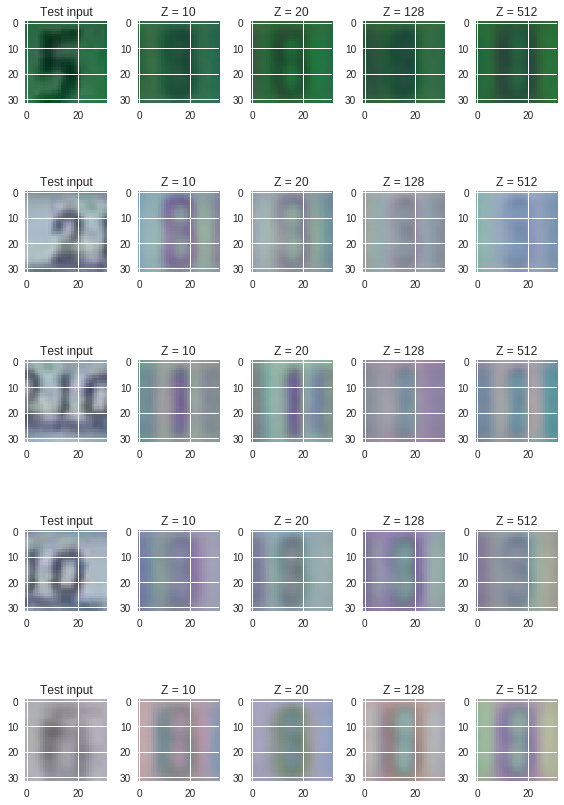

In [0]:
# Final change of latent dimension comparison
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 5, 5*i + 1)
    plt.imshow(x_sample[i])
    plt.title("Test input")
    plt.subplot(5, 5, 5*i + 2)
    plt.imshow(x_reconstruct_10[i])
    plt.title("Z = 10")
    plt.subplot(5, 5, 5*i + 3)
    plt.imshow(x_reconstruct[i])
    plt.title("Z = 20")
    plt.subplot(5, 5, 5*i + 4)
    plt.imshow(x_reconstruct_128[i])
    plt.title("Z = 128")
    plt.subplot(5, 5, 5*i + 5)
    plt.imshow(x_reconstruct_512[i])
    plt.title("Z = 512")
plt.tight_layout()
plt.savefig('change of latent dimension')

In [0]:
# change arch 200
network_architecture = dict(n_hidden_recog_1=200, # 1st layer encoder neurons
                            n_hidden_recog_2=200, # 2nd layer encoder neurons
                            n_hidden_gener_1=200, # 1st layer decoder neurons
                            n_hidden_gener_2=200, # 2nd layer decoder neurons
                            n_input=1024, # 
                            n_z=20)  # dimensionality of latent space

vae_arch200_R = train(dataset_R, network_architecture, training_epochs=10, batch_size=100)
vae_arch200_G = train(dataset_G, network_architecture, training_epochs=10, batch_size=100)
vae_arch200_B = train(dataset_B, network_architecture, training_epochs=10, batch_size=100)

In [0]:
# test outputs
x_reconstruct_R_arch200 = vae_arch200_R.reconstruct(x_sample_R.reshape(100,1024)).reshape(100, 32, 32)
x_reconstruct_G_arch200 = vae_arch200_G.reconstruct(x_sample_G.reshape(100,1024)).reshape(100, 32, 32)
x_reconstruct_B_arch200 = vae_arch200_B.reconstruct(x_sample_B.reshape(100,1024)).reshape(100, 32, 32)

# combine sample array
x_reconstruct_arch200 = np.transpose(np.stack((x_reconstruct_R_arch200, x_reconstruct_G_arch200, x_reconstruct_B_arch200)), (1, 2, 3, 0))

In [0]:
# change arch 1000
network_architecture = dict(n_hidden_recog_1=1000, # 1st layer encoder neurons
                            n_hidden_recog_2=1000, # 2nd layer encoder neurons
                            n_hidden_gener_1=1000, # 1st layer decoder neurons
                            n_hidden_gener_2=1000, # 2nd layer decoder neurons
                            n_input=1024, # 
                            n_z=20)  # dimensionality of latent space

vae_arch1000_R = train(dataset_R, network_architecture, training_epochs=10, batch_size=100)
vae_arch1000_G = train(dataset_G, network_architecture, training_epochs=10, batch_size=100)
vae_arch1000_B = train(dataset_B, network_architecture, training_epochs=10, batch_size=100)

In [0]:
# test outputs
x_reconstruct_R_arch1000 = vae_arch1000_R.reconstruct(x_sample_R.reshape(100,1024)).reshape(100, 32, 32)
x_reconstruct_G_arch1000 = vae_arch1000_G.reconstruct(x_sample_G.reshape(100,1024)).reshape(100, 32, 32)
x_reconstruct_B_arch1000 = vae_arch1000_B.reconstruct(x_sample_B.reshape(100,1024)).reshape(100, 32, 32)

# combine sample array
x_reconstruct_arch1000 = np.transpose(np.stack((x_reconstruct_R_arch1000, x_reconstruct_G_arch1000, x_reconstruct_B_arch1000)), (1, 2, 3, 0))

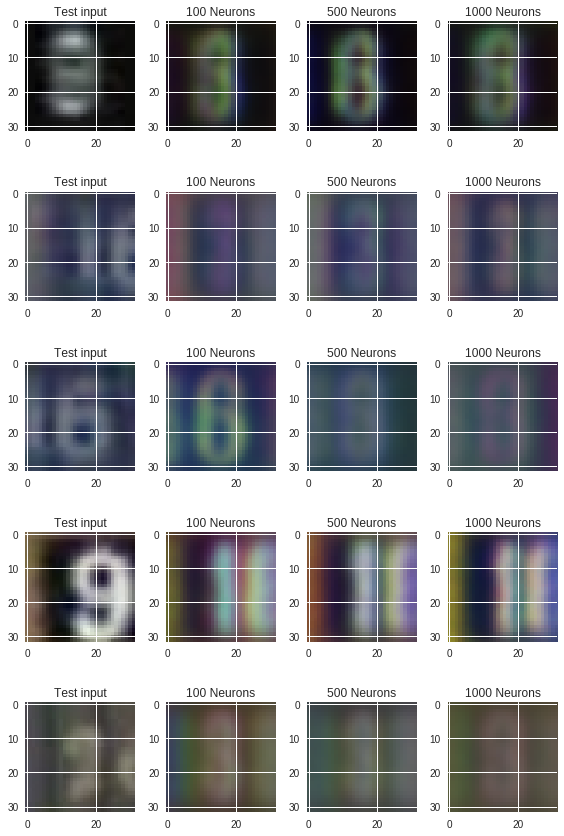

In [0]:
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 4, 4*i + 1)
    plt.imshow(x_sample[i+40])
    plt.title("Test input")
    plt.subplot(5, 4, 4*i + 2)
    plt.imshow(x_reconstruct_arch200[i+40])
    plt.title("100 Neurons")
    plt.subplot(5, 4, 4*i + 3)
    plt.imshow(x_reconstruct[i+40])
    plt.title("500 Neurons")
    plt.subplot(5, 4, 4*i + 4)
    plt.imshow(x_reconstruct_arch1000[i+40])
    plt.title("1000 Neurons")
plt.tight_layout()
plt.savefig('change of neuron')

In [0]:
# different neuron per layer
# 500 1000
network_architecture = dict(n_hidden_recog_1=500, # 1st layer encoder neurons
                            n_hidden_recog_2=1000, # 2nd layer encoder neurons
                            n_hidden_gener_1=1000, # 1st layer decoder neurons
                            n_hidden_gener_2=500, # 2nd layer decoder neurons
                            n_input=1024, # 
                            n_z=20)  # dimensionality of latent space

vae_arch510_R = train(dataset_R, network_architecture, training_epochs=10, batch_size=100)
vae_arch510_G = train(dataset_G, network_architecture, training_epochs=10, batch_size=100)
vae_arch510_B = train(dataset_B, network_architecture, training_epochs=10, batch_size=100)

In [0]:
# test outputs
x_reconstruct_R_arch510 = vae_arch510_R.reconstruct(x_sample_R.reshape(100,1024)).reshape(100, 32, 32)
x_reconstruct_G_arch510 = vae_arch510_G.reconstruct(x_sample_G.reshape(100,1024)).reshape(100, 32, 32)
x_reconstruct_B_arch510 = vae_arch510_B.reconstruct(x_sample_B.reshape(100,1024)).reshape(100, 32, 32)

# combine sample array
x_reconstruct_arch510 = np.transpose(np.stack((x_reconstruct_R_arch510, x_reconstruct_G_arch510, x_reconstruct_B_arch510)), (1, 2, 3, 0))

In [0]:
# 500 200
network_architecture = dict(n_hidden_recog_1=500, # 1st layer encoder neurons
                            n_hidden_recog_2=200, # 2nd layer encoder neurons
                            n_hidden_gener_1=200, # 1st layer decoder neurons
                            n_hidden_gener_2=500, # 2nd layer decoder neurons
                            n_input=1024, # 
                            n_z=20)  # dimensionality of latent space

vae_arch52_R = train(dataset_R, network_architecture, training_epochs=10, batch_size=100)
vae_arch52_G = train(dataset_G, network_architecture, training_epochs=10, batch_size=100)
vae_arch52_B = train(dataset_B, network_architecture, training_epochs=10, batch_size=100)

In [0]:
# test outputs
x_reconstruct_R_arch52 = vae_arch52_R.reconstruct(x_sample_R.reshape(100,1024)).reshape(100, 32, 32)
x_reconstruct_G_arch52 = vae_arch52_G.reconstruct(x_sample_G.reshape(100,1024)).reshape(100, 32, 32)
x_reconstruct_B_arch52 = vae_arch52_B.reconstruct(x_sample_B.reshape(100,1024)).reshape(100, 32, 32)

# combine sample array
x_reconstruct_arch52 = np.transpose(np.stack((x_reconstruct_R_arch52, x_reconstruct_G_arch52, x_reconstruct_B_arch52)), (1, 2, 3, 0))

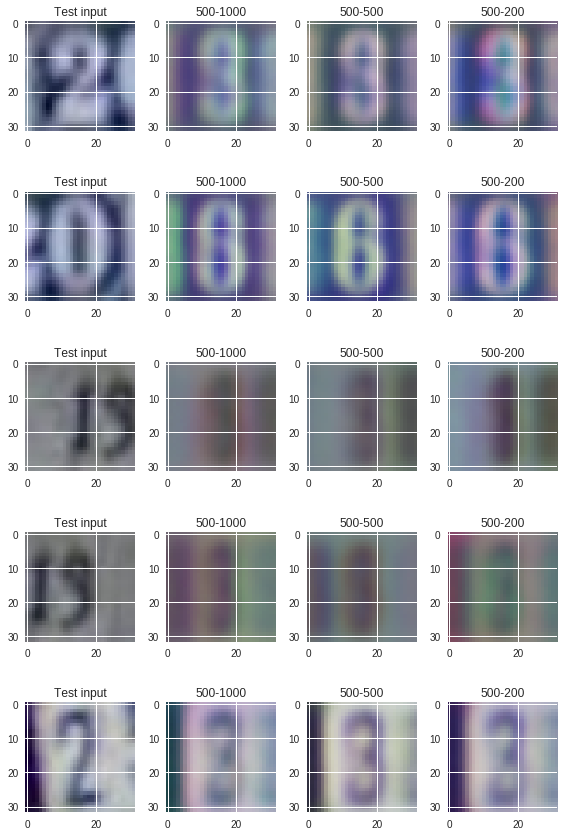

In [0]:
# unequal layer width comparison
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 4, 4*i + 1)
    plt.imshow(x_sample[i+20])
    plt.title("Test input")
    plt.subplot(5, 4, 4*i + 2)
    plt.imshow(x_reconstruct_arch510[i+20])
    plt.title("500-1000")
    plt.subplot(5, 4, 4*i + 3)
    plt.imshow(x_reconstruct[i+20])
    plt.title("500-500")
    plt.subplot(5, 4, 4*i + 4)
    plt.imshow(x_reconstruct_arch52[i+20])
    plt.title("500-200")
plt.tight_layout()
plt.savefig('change of arch')

In [0]:
# epoch 50
network_architecture = dict(n_hidden_recog_1=500, # 1st layer encoder neurons
                            n_hidden_recog_2=500, # 2nd layer encoder neurons
                            n_hidden_gener_1=500, # 1st layer decoder neurons
                            n_hidden_gener_2=500, # 2nd layer decoder neurons
                            n_input=1024, # 
                            n_z=20)  # dimensionality of latent space

vae_ep20_R = train(dataset_R, network_architecture, training_epochs=20, batch_size=100)
vae_ep20_G = train(dataset_G, network_architecture, training_epochs=20, batch_size=100)
vae_ep20_B = train(dataset_B, network_architecture, training_epochs=20, batch_size=100)

In [0]:
# test outputs
x_reconstruct_R_ep20 = vae_ep20_R.reconstruct(x_sample_R.reshape(100,1024)).reshape(100, 32, 32)
x_reconstruct_G_ep20 = vae_ep20_G.reconstruct(x_sample_G.reshape(100,1024)).reshape(100, 32, 32)
x_reconstruct_B_ep20 = vae_ep20_B.reconstruct(x_sample_B.reshape(100,1024)).reshape(100, 32, 32)

# combine sample array
x_reconstruct_ep20 = np.transpose(np.stack((x_reconstruct_R_ep20, x_reconstruct_G_ep20, x_reconstruct_B_ep20)), (1, 2, 3, 0))

In [30]:
# epoch 50
vae_ep50_R = train(dataset_R, network_architecture, training_epochs=50, batch_size=100)
vae_ep50_G = train(dataset_G, network_architecture, training_epochs=50, batch_size=100)
vae_ep50_B = train(dataset_B, network_architecture, training_epochs=50, batch_size=100)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 0001 cost= 658.254417877
Epoch: 0002 cost= 646.337737489
Epoch: 0003 cost= 645.663480101
Epoch: 0004 cost= 645.219225197
Epoch: 0005 cost= 644.715953479
Epoch: 0006 cost= 644.304410626
Epoch: 0007 cost= 644.053532447
Epoch: 0008 cost= 643.924421225
Epoch: 0009 cost= 643.655349975
Epoch: 0010 cost= 643.425170860
Epoch: 0011 cost= 643.254400730
Epoch: 0012 cost= 643.219624347
Epoch: 0013 cost= 643.166859518
Epoch: 0014 cost= 643.105589992
Epoch: 0015 cost= 643.048043297
Epoch: 0016 cost= 642.942863735
Epoch: 0017 cost= 642.884061711
Epoch: 0018 cost= 642.780325524
Epoch: 0019 cost= 642.718020541
Epoch: 0020 cost= 642.645317494
Epoch: 0021 cost= 642.599877851
Epoch: 0022 cost= 642.515166233
Epoch: 0023 cost= 642.495633683
Epoch: 0024 cost= 642.396848995
Epoch: 0025 cost= 642.323773773
Epoch: 0026 cost= 642.307040074
Epoch: 0027 cost= 642.204545469
Epoch: 0028 cost= 642.211179794
Epoch: 0029 cost= 642.203682227
Epoch: 0030 cost= 642.149017116
Epoch: 0031 cost= 642.136165049
Epoch: 0

ResourceExhaustedError: ignored

In [0]:
# test outputs
x_reconstruct_R_ep50 = vae_ep50_R.reconstruct(x_sample_R.reshape(100,1024)).reshape(100, 32, 32)
x_reconstruct_G_ep50 = vae_ep50_G.reconstruct(x_sample_G.reshape(100,1024)).reshape(100, 32, 32)
x_reconstruct_B_ep50 = vae_ep50_B.reconstruct(x_sample_B.reshape(100,1024)).reshape(100, 32, 32)

# combine sample array
x_reconstruct_ep50 = np.transpose(np.stack((x_reconstruct_R_ep50, x_reconstruct_G_ep50, x_reconstruct_B_ep50)), (1, 2, 3, 0))

In [0]:
# comparison of different epochs
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 4, 4*i + 1)
    plt.imshow(x_sample[i+20])
    plt.title("Test input")
    plt.subplot(5, 4, 4*i + 2)
    plt.imshow(x_reconstruct[i+20])
    plt.title("epoch = 10")
    plt.subplot(5, 4, 4*i + 3)
    plt.imshow(x_reconstruct_ep20[i+20])
    plt.title("epoch = 20")
    plt.subplot(5, 4, 4*i + 4)
    plt.imshow(x_reconstruct_ep50[i+20])
    plt.title("epoch = 50")
plt.tight_layout()
plt.savefig('change of epoch')